# Self Driving Mario Kart with OpenCV
#### Team members: Ingrid Hansen, Iris Loret, Dina Boshnaq
#### Group 2

## Introduction
For this project we decided to go with the self driving car. For this we chose the mario kart game which we ran through the dolphin emulator. Through the OpenCV library, we capture the image, manipulate it, and add edge detection. The lane lines are detected and the optimal direction for the car is calculated.

Let's get started by first importing the necessary libraries for computer vision, image processing, and input control (which will be used to determine the keys pressed at the time of each screenshot, and for driving later on).

In [1]:
import cv2  # OpenCV for image processing
import numpy as np  # NumPy for numerical operations
import matplotlib.pyplot as plt  # Matplotlib for visualization
import mss  # MSS for screen capturing
import uuid  # UUID for generating unique identifiers
import mss.tools  # Tools from MSS for image processing
import time  # Time for handling delays
import keyboard  # Keyboard for monitoring key presses
import pyautogui  # PyAutoGUI for controlling the mouse and keyboard
import math  # Math for mathematical operations
import sys # System

## Taking Screenshots
Next, we will start taking screenshots while playing the game through the MSS library to test different canny edge detection and blurring effects on them. We are only taking the ROI (Region Of Interest) which is 2/3 of the screen. This will capture the road up to a certain point in the horizon while not including any uncessary background that may cause confusion when we apply edge detection and draw the lines. The goal is to just get the lines on the side of the road.

In [ ]:
# 5 second waiting time to give us a chance to start the game
time.sleep(5)
 
# Create a screen capturing instance using mss
with mss.mss() as sct:
    # Get information about the primary monitor
    # Note: This is useful in case there's and extra monitor but the game is on the primary one
    monitor_info = sct.monitors[0]
    # Calculate the top margin for capturing a portion of the screen
    top_margin = monitor_info["height"] // 3
    # Define the region of the screen to capture
    monitor = {
        "top": monitor_info["top"] + top_margin, 
        "left": monitor_info["left"]+55, 
        "width": monitor_info["width"]-120, 
        "height": (monitor_info["height"] * 2 // 3)-55
    }
 
    # Continue taking screenshots until the space key is pressed
    while not keyboard.is_pressed("space"):
        # Generate a unique filename using uuid
        output = f"dataset/{str(uuid.uuid4())}.png".format(**monitor)
        # Capture the ROI of the screen
        sct_img = sct.grab(monitor)
        # Convert image to PNG and save it
        mss.tools.to_png(sct_img.rgb, sct_img.size, output=output)
        print(f"Captured {output}")
        # Specify the capture rate: Every half a second take a screenshot
        time.sleep(0.5)

We run the code and save all the images in the dataset folder.
We had originally thought that we'd be using the images in the deep learning model, but later on we found out that this is not the case. Nonetheless, they were used to detect any problems when applying edge detection and blurring.

## Exploring Canny Edge Detection and Blurring Effects

In this code, we apply Canny edge detection and blurring techniques on a sample image from the data we collected. We add Canny edge detection without prior blurring, followed by applying blurring with different kernel sizes (3x3 and 5x5). We will explore the consequences of altering the lower and upper thresholds in Canny edge detection, showing the different effects this has on image sharpness and feature visibility. Image preprocessing can influence the final outcome which is why we're doing these steps to find the best settings for enhancing image features and optimizing the overall quality of the processed image.

Note: We applied the following on multiple images to test around, but we're only showcasing one of them in here for the report.

(-0.5, 1799.5, 664.5, -0.5)

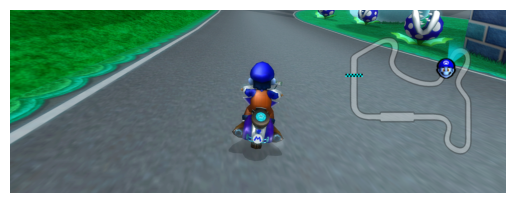

In [2]:
# Load the original sample image in BGR (Blue, Green, Red) format
img_orig = cv2.imread('dataset/9f191f48-fc18-42f2-b2cf-9badd9ae2192.png')
plt.imshow(img_orig)
plt.axis('off')

(-0.5, 1799.5, 664.5, -0.5)

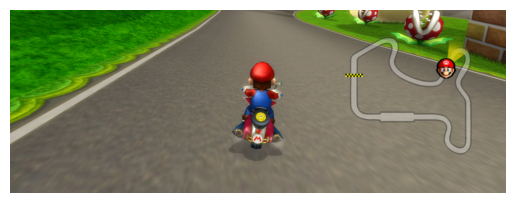

In [4]:
# Convert the image from BGR (Blue, Green, Red) to RGB (Red, Green, Blue)
img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')

(-0.5, 1799.5, 664.5, -0.5)

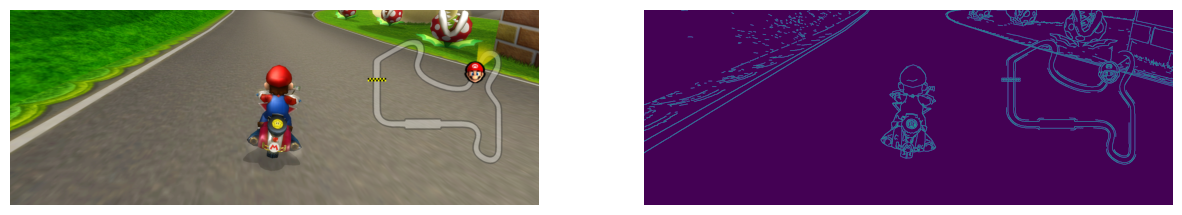

In [49]:
# Canny detection without blurring
img_canny = cv2.Canny(img_orig, threshold1=121.6, threshold2=180.9)
# Create a subplot for side-by-side comparison of the original in RGB and Canny edges
plt.figure(figsize = (15, 15))
plt.subplot(1, 2, 1); plt.imshow(img_rgb)
plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(img_canny)
plt.axis('off')

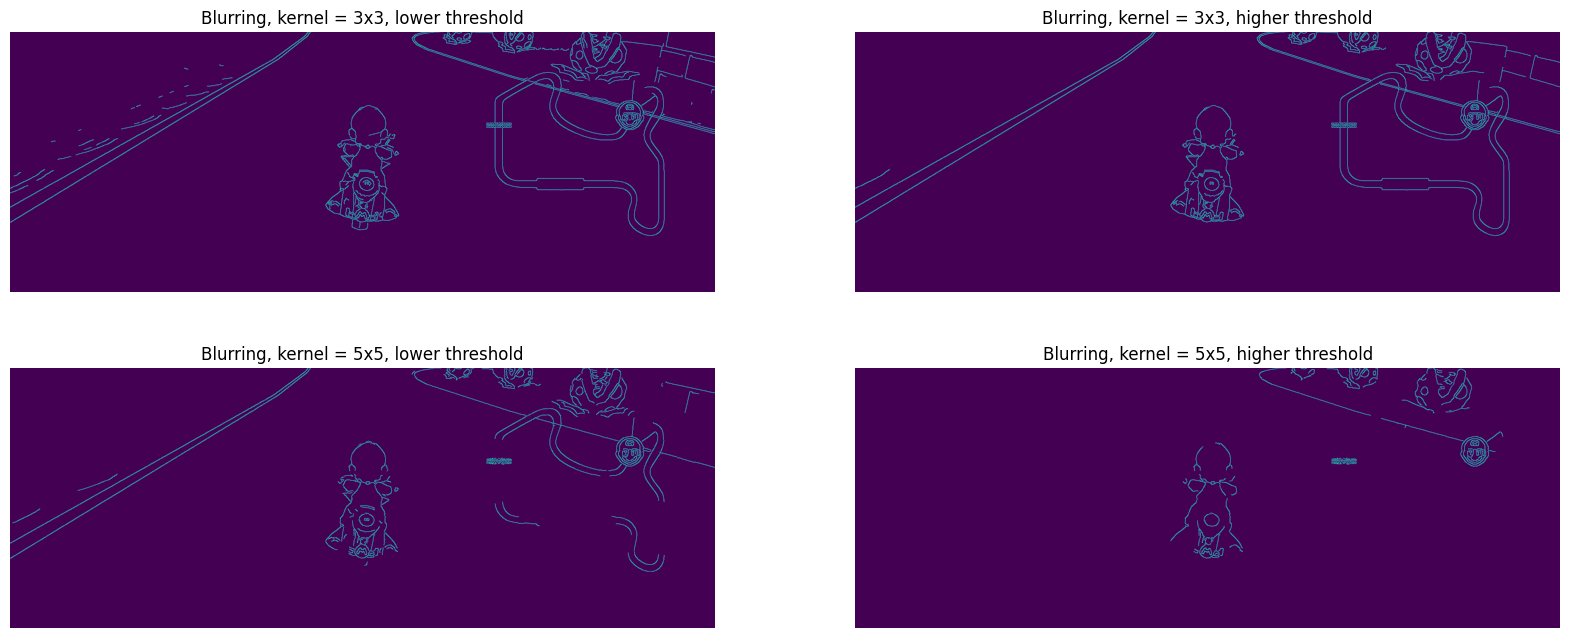

In [5]:
# Set the lower and upper threshold for Canny edge detection
med_val = np.median(img_orig)
lower = 121.6
upper = 180.9

# Apply blurring with a kernel size of 3x3
img_k3 = cv2.blur(img_orig, ksize = (3, 3))
# Canny detection with different thresholds
edges_k3 = cv2.Canny(img_k3, threshold1 = lower, threshold2 = upper)
edges_k3_2 = cv2.Canny(img_k3, lower, upper + 75)

# Apply blurring with a kernel size of 5x5
img_k5 = cv2.blur(img_orig, ksize = (5, 5))
# Canny detection with different thresholds
edges_k5 = cv2.Canny(img_k5, lower, upper)
edges_k5_2 = cv2.Canny(img_k5, lower, upper + 75)

# Plot the images with different blurring and thresholding parameters
images = [edges_k3, edges_k3_2, edges_k5, edges_k5_2]
titles = ['Blurring, kernel = 3x3, lower threshold', 
          'Blurring, kernel = 3x3, higher threshold', 
          'Blurring, kernel = 5x5, lower threshold', 
          'Blurring, kernel = 5x5, higher threshold']
plt.figure(figsize = (20, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(titles[i])
        
plt.show()

From this comparison we can conclude that the 5x5 kernel and lower threshold is the best. This will be the option that we will work with.

(-0.5, 1799.5, 664.5, -0.5)

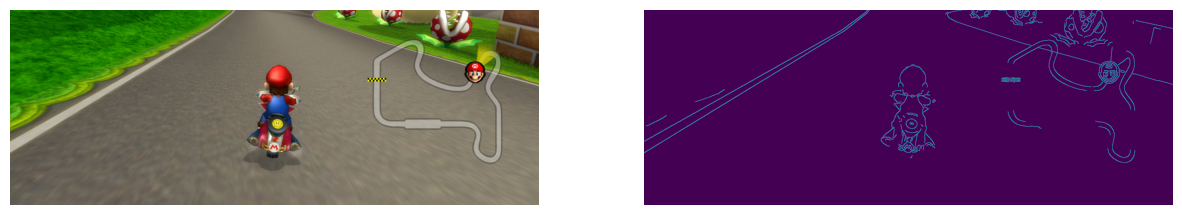

In [51]:
# Canny detection with blurring
img_blur = cv2.blur(img_orig, ksize = (5, 5))
img_canny = cv2.Canny(img_blur, threshold1=121.6, threshold2=180.9)
plt.figure(figsize = (15, 15))
plt.subplot(1, 2, 1); plt.imshow(img_rgb)
plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(img_canny)
plt.axis('off')

In [ ]:
# Display a screen with the source image and one with the added lines
def main(argv):
    dst = img_canny
    # Copy edges to the images that will display the results in BGR
    cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
    cdstP = np.copy(cdst)
    # Apply Probabilistic Hough Line Transform to detect the lines
    linesP = cv2.HoughLinesP(dst, 1, np.pi / 250, 90, None, 94.6, 20.5)
    # If there are lines, draw them on the image
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
   # Show the images in a new window
    cv2.imshow("Source", dst)
    cv2.imshow("Detected Lines (in red) - Probabilistic Line Transform", cdstP)
   
    cv2.waitKey()
    return 0
   
if __name__ == "__main__":
    main(sys.argv[1:])

<img src="redBlackImageBlurred.jpg" width="700"/>

After experimenting with OpenCV and knowing which kernel and thresholds work best for our use case, it's time to let Mario drive.

## Let's run Mario!

Here we will make three functions:
- Screenshot: For taking screenshots of the current screen in the game.
- Drive: For processing the image to identify the path. It applies Canny edge detection and Hough line transformation to extract prominent features in the image. Based on the detected lines, it determines the direction for navigation, classifying scenarios as forward, left, right, or back.
- Move: For translating the navigation labels into corresponding keyboard and mouse actions to simulate movement (to make it self-drive).

<p>
The entire process is in a continuous loop, creating a simple autonomous navigation system that responds to the space key to stop.
</p>

The logic of our code is to grab the furthest (x,y) coordinates of the line from mario on both sides of the road. The distance between the two should be the length of the horizon in the image. We divide that distance in half to get the x coordinate of the center of the road which is where Mario needs to be.

Mario is always in the center of the screen, so his x coordinate is always 900 (the screen is 1800, 1800/2=900). The goal is to have Mario's x point equal to the desired x point. This ensures he is in the center of the road. We will explain in the code the logic we used to do so.

In [ ]:
# Function to capture a screenshot and save it to a specified folder
def screenshot():
    with mss.mss() as sct:
        time.sleep(1)
        monitor_info = sct.monitors[0]
        top_margin = (monitor_info["height"] // 3) + 50
        monitor = {"top": monitor_info["top"] + top_margin, "left": monitor_info["left"] + 55, "width": monitor_info["width"] - 120, "height": (monitor_info["height"] * 2 // 3)-105}
        output = f"testimages/{str(uuid.uuid4())}.png".format(**monitor)
        sct_img = sct.grab(monitor)
        mss.tools.to_png(sct_img.rgb, sct_img.size, output=output)
    # We return the file path
    return output
 
# Function to analyze the captured image, determine navigation, and return a label    
def drive():
    # Capture a screenshot and obtain the file path
    img_path = screenshot()
    # Read the image using OpenCV
    img_orig = cv2.imread(img_path)
    # Apply blurring to reduce noise and enhance edges
    img_blur = cv2.blur(img_orig, ksize=(5, 5))
    # Apply Canny edge detection to identify prominent edges
    img_canny = cv2.Canny(img_blur, threshold1=121.6, threshold2=180.9)
    # Convert the single-channel Canny image to a 3-channel RGB image
    cdst = cv2.cvtColor(img_canny, cv2.COLOR_GRAY2RGB)
    # Apply Probabilistic Hough Line Transform to detect lines in the Canny image
    linesP = cv2.HoughLinesP(img_canny, 1, np.pi / 250, 90, None, 94.6, 20.5)
   
    # If there are lines found, extract the coordinates and draw the line
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv2.line(cdst, (l[0], l[1]), (l[2], l[3]), (0, 0, 255), 3, cv2.LINE_AA)
   
    image_width = 1800
    threshold = (image_width // 2) -60  # Half of the image width - 60 to avoid problem nr 3
 
    # Separate left and right coordinates based on the threshold
    left_y = []
    left_x = []
    right_y = []
    right_x = []
    if linesP is not None:
        for line in linesP:
            x1, y1, x2, y2 = line[0]
            # Separate coordinates into left and right sides
            if x1 < threshold and x2 < threshold:
                left_y.extend([y1, y2])
                left_x.extend([x1, x2])
            elif x1 >= threshold and x2 >= threshold:
                right_y.extend([y1, y2])
                right_x.extend([x1, x2])
 
    # Find the lowest Y coordinates on the left and right sides
    if left_y:
        left_lowest_index = left_y.index(min(left_y))
        x1_left_lowest, y1_left_lowest = left_x[left_lowest_index], left_y[left_lowest_index]
        cv2.circle(cdst, (x1_left_lowest, y1_left_lowest), 10, (0, 0, 255), -1)  # Mark left lowest point in red
 
    if right_y:
        right_lowest_index = right_y.index(min(right_y))
        x2_right_lowest, y2_right_lowest = right_x[right_lowest_index], right_y[right_lowest_index]
        cv2.circle(cdst, (x2_right_lowest, y2_right_lowest), 10, (0, 0, 255), -1)  # Mark right lowest point in red
 
    # If there is no left line, go to the left
    if right_y and not left_y:
        label = 'left'
        print("right line only")
        return label
   
    # If there is no right line, go to the right
    elif left_y and not right_y:
        label = 'right'
        print("left line only")
        return label
    
    # If it doesn't see any lines go backwards
    elif not left_y and not right_x:
        label = 'back'
        return label
    
    # If there are 2 lines calculate the distance between the horizon points and calculate the direction
    elif right_y and left_y:
        # Calculate Euclidean distance
        distance = math.sqrt((x2_right_lowest - x1_left_lowest)**2 + (y2_right_lowest - y1_left_lowest)**2)
        print("Distance between the points:", distance)

        # Get the center of the distance between the points
        center = distance / 2
        print('Center:', center)

        # Calculate the point where mario should go to and where he is now
        desired_x_point = x1_left_lowest + center
        mario_x_point = 900
        print('Desired x point:', desired_x_point)

        # Calculate the distance to the center
        distance_to_center = desired_x_point - mario_x_point
        print(distance_to_center)

        # If the distance to the center is between 0 and 80, go forward
        if(distance_to_center >= 0 and distance_to_center <= 80):
            label = 'forward'

        # If the distance to the center is smaller then 0, go to the left
        if(distance_to_center < 0 ):
            label = 'left'

        # If the distance to the center is bigger then 80, go to the right
        if(distance_to_center > 80):
            label = 'right'
 
        print(label)
        return label
   
# Function to execute corresponding actions based on the navigation label
def move():
    # Get the label by calling the drive function
    label = drive()
    print(label)
    # If the label is right, press d and go forward
    if (label == 'right'):
        keyboard.press('d')
        pyautogui.mouseDown(button='left')
        time.sleep(0.15)
        pyautogui.mouseUp(button='left')
        keyboard.release('d')
    # If the label is left, press q and go forward
    if (label == 'left'):
        keyboard.press('q')
        pyautogui.mouseDown(button='left')
        time.sleep(0.15)
        pyautogui.mouseUp(button='left')
        keyboard.release('q')
    # If the label is forward, go forward
    if(label == 'forward'):
        pyautogui.mouseDown(button='left')
        time.sleep(0.3)
        pyautogui.mouseUp(button='left')
    # If the label is back, go backwards
    if(label == 'back'):
        pyautogui.mouseDown(button='right')
        time.sleep(0.3)
        pyautogui.mouseUp(button='right')
 
time.sleep(5)
while not keyboard.is_pressed("space"):
    move()

## Problems we encountered

1. Problem areas

Mario struggles with different problem areas when he drives. We noticed these areas are different on each of our laptops. The reason for this difference isn't known to us. However, one of the issues we found is that when applying the Probabilistic Hough Lines to an image with blurring, the results differs from using it on an image withour blurring. 
We had initially used blurring on the original image to get the most important and prominant lines instead of too many lines. But then we realized that, in some cases, this caused certain lines that should be outlined to not be outlined.

An example of a normal image with and without blurring:
- Original Image:

<img src="dataset/9f191f48-fc18-42f2-b2cf-9badd9ae2192.png" width="700"/>

- With Blurring:

<img src="blurringFine.jpg" width="700"/>

- Without Blurring:

<img src="noBlurring.jpg" width="700"/>

As we see, the image here is just fine when adding Hough LinesP with or without blurring. But with blurring it's more clean.

An example of a problem area image with and without blurring:
- Original Image:

<img src="dataset/3f8219cd-7c31-422f-9996-ce145d1c900e.png" width="700"/>

- With Blurring:

<img src="sandProblemArea.jpg" width="700"/>

- Without Blurring:

<img src="sandWithoutBlurring.jpg" width="700"/>

As you can see, the sand is quite the problem area as it doesn't see it when adding blurring which then causes Mario to drive over it thinking it's the road.

And the problem is, we can't exactly go around trying every single image to see if it gets outlined with lines or not when adding blurring. So, we decided to test it while driving, with blurring and without. We noticed that without blurring it drove even worse, so we just kept the blurring.


2. Defining the right horizon coordinates

Another issue that we had is getting the coordinates of the horizon of the road. Initially we had tried to get them by getting the points with the lowest y values which would be the ones at the very top of the screen. But the problem arised when we noticed that in some images, the coordinates were on the same side of the road. This would not capture the horizon. So, to solve it we split the screen into right and left, then took the lowest y values on each side independantly.

Let's look at an example. In the following image, the two lowest y values (closest to the top of the image) are both on the right side of the screen. So when trying to calculate the distance between them, we don't get the horizon.

<img src="dotLinesIssue.jpg" width="700"/>


3. Dealing with horizons at a sharp turn

We solved the previous problem by splitting the screen in half into right and left sides. But, this caused a new issue, specific to sharp turns. In some images, the turn is very sharp that one of the horizon coordinates is on the same side as the other one by a very slight value (right next to the middle of the screen). This caused issues for some images where it would make Mario go straight instead of turning. So, we excluded 60 pixels in the center of the screen to solve this small issue.

## Conclusion


In conclusion, we can say that Mario can drive some parts of this specific course on his own, but in some parts of the track he still has a hard time figuring out which direction he should go. But we can conclude that OpenCV worked well for this assignment. 

Throughout this assignment we learned how to use OpenCV, how to capture the screen in a script and to guide Mario in a specific direction by calculating where the center of the horizon of the road is. This taught us a lot about what's possible with computer vision.

What we would have done differently is maybe tweak the parameters a bit more to figure out if there were better outcomes of capturing the lines.

We are proud of the way Mario can correct himself by going backwards and that he is able to drive most part of the track. 